# Separate Light profile with PSF

#### First import modules ####

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting

from dysmalpy.fitting_wrappers import tied_functions

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

##### Setup notebook #####

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

In [4]:
from importlib import reload

-----------

### Hack 1: BH with Sersic=1

In [5]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [6]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [7]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [8]:
BH = models.BlackHole(BH_mass=9.,name='BH')
LSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., name='LSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [9]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [10]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [11]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [12]:
mod_setFO.add_component(BH)
mod_setFO.add_component(LSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [13]:
mod_setEO.add_component(BH)
mod_setEO.add_component(LSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [14]:
beamsize = 0.2*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

# beam = None
# lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

In [15]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [16]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

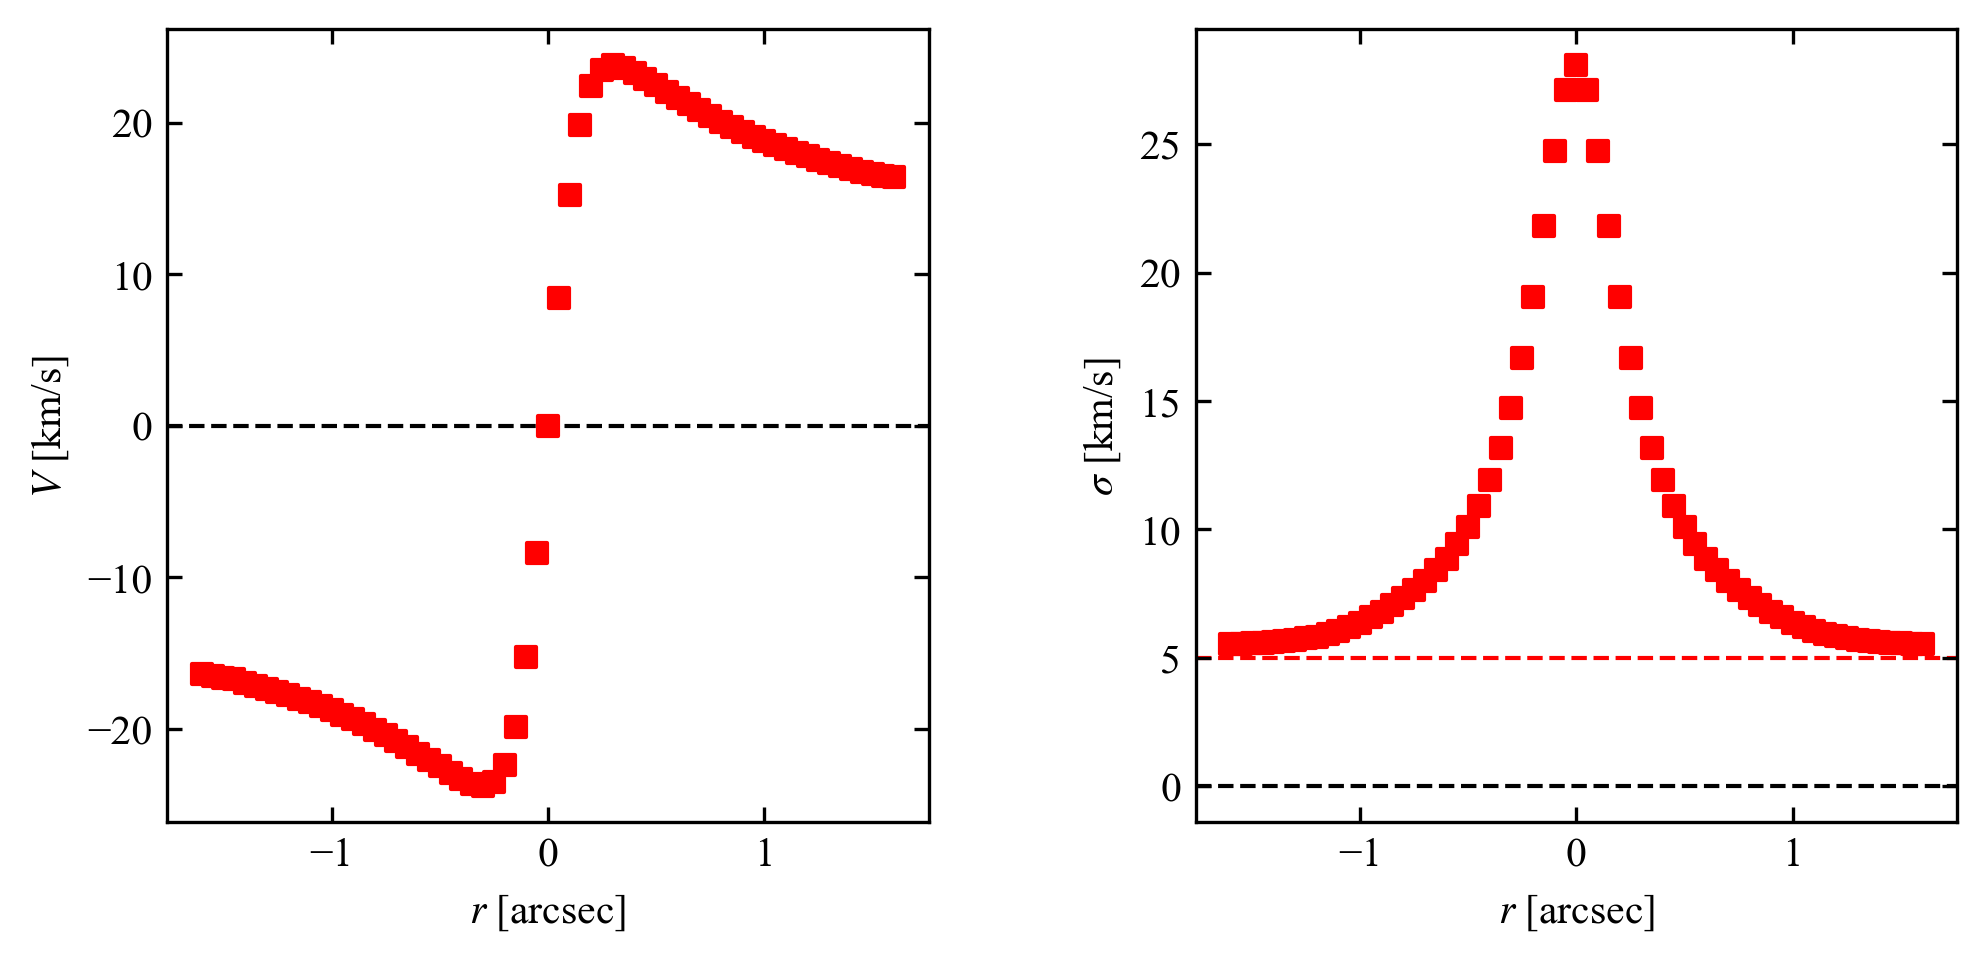

In [17]:
plotting.plot_model_1D(galEO, inst_corr=True, best_dispersion=sigma0)

### 2D model

In [18]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

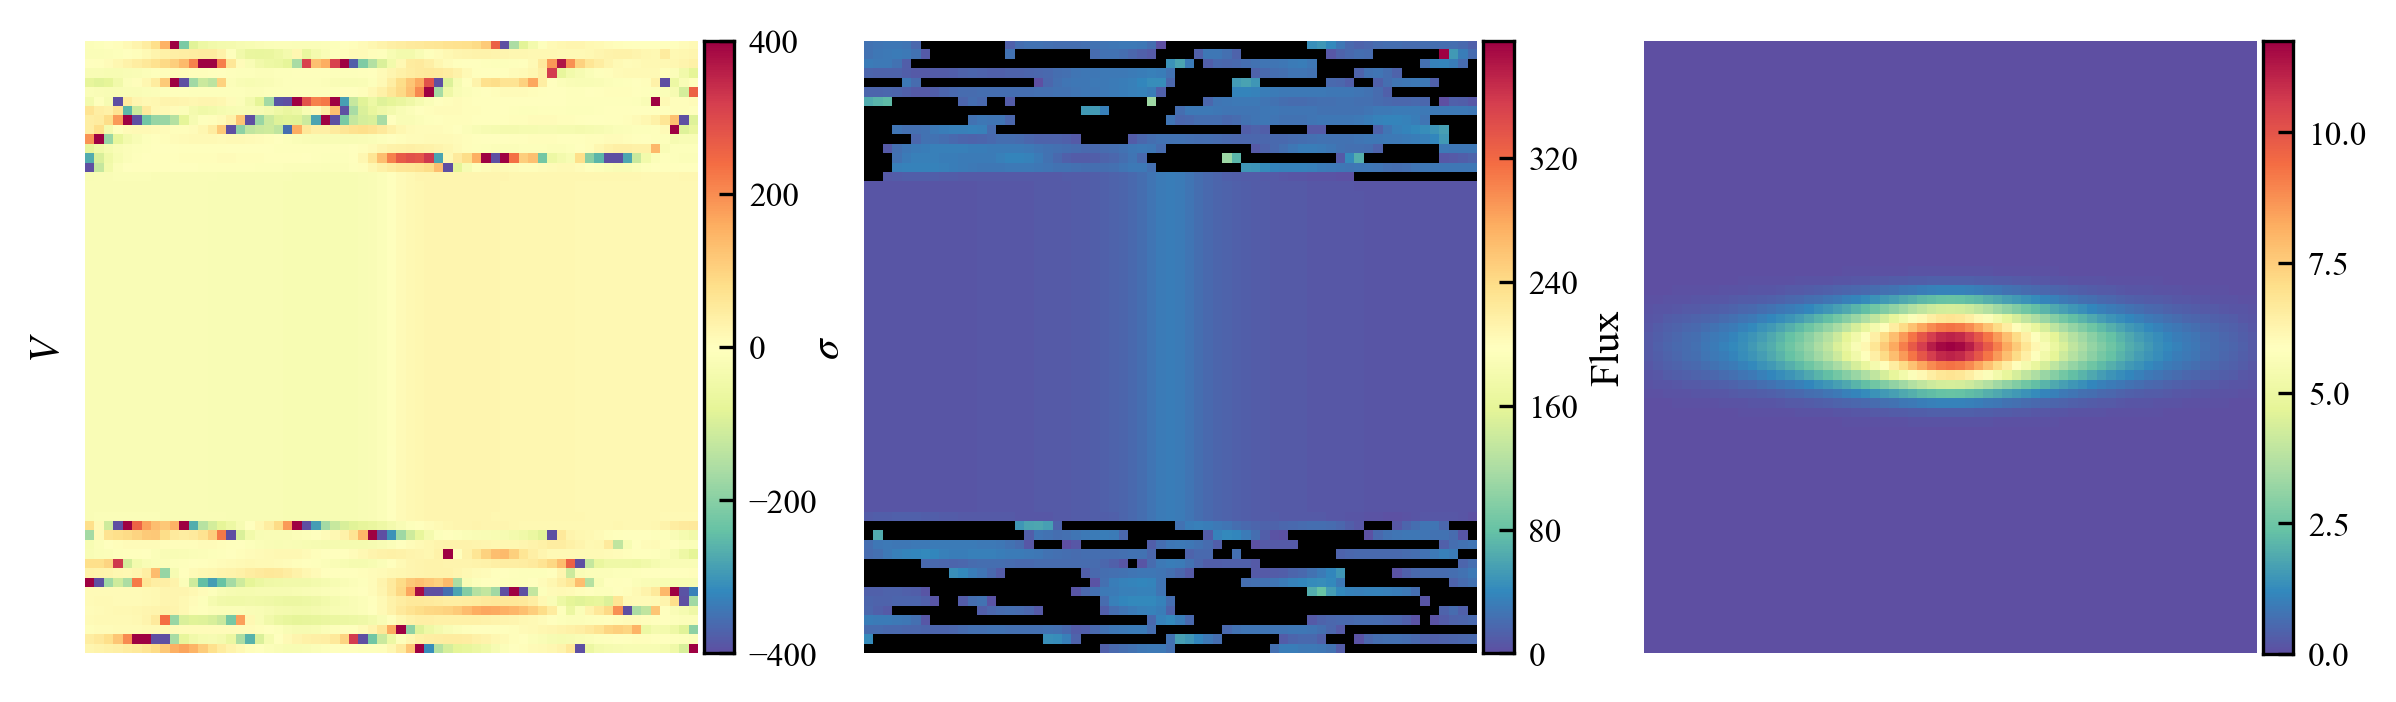

In [19]:
plotting.plot_model_2D(galEO, inst_corr=True, fitflux=True)

### 2D model

In [20]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

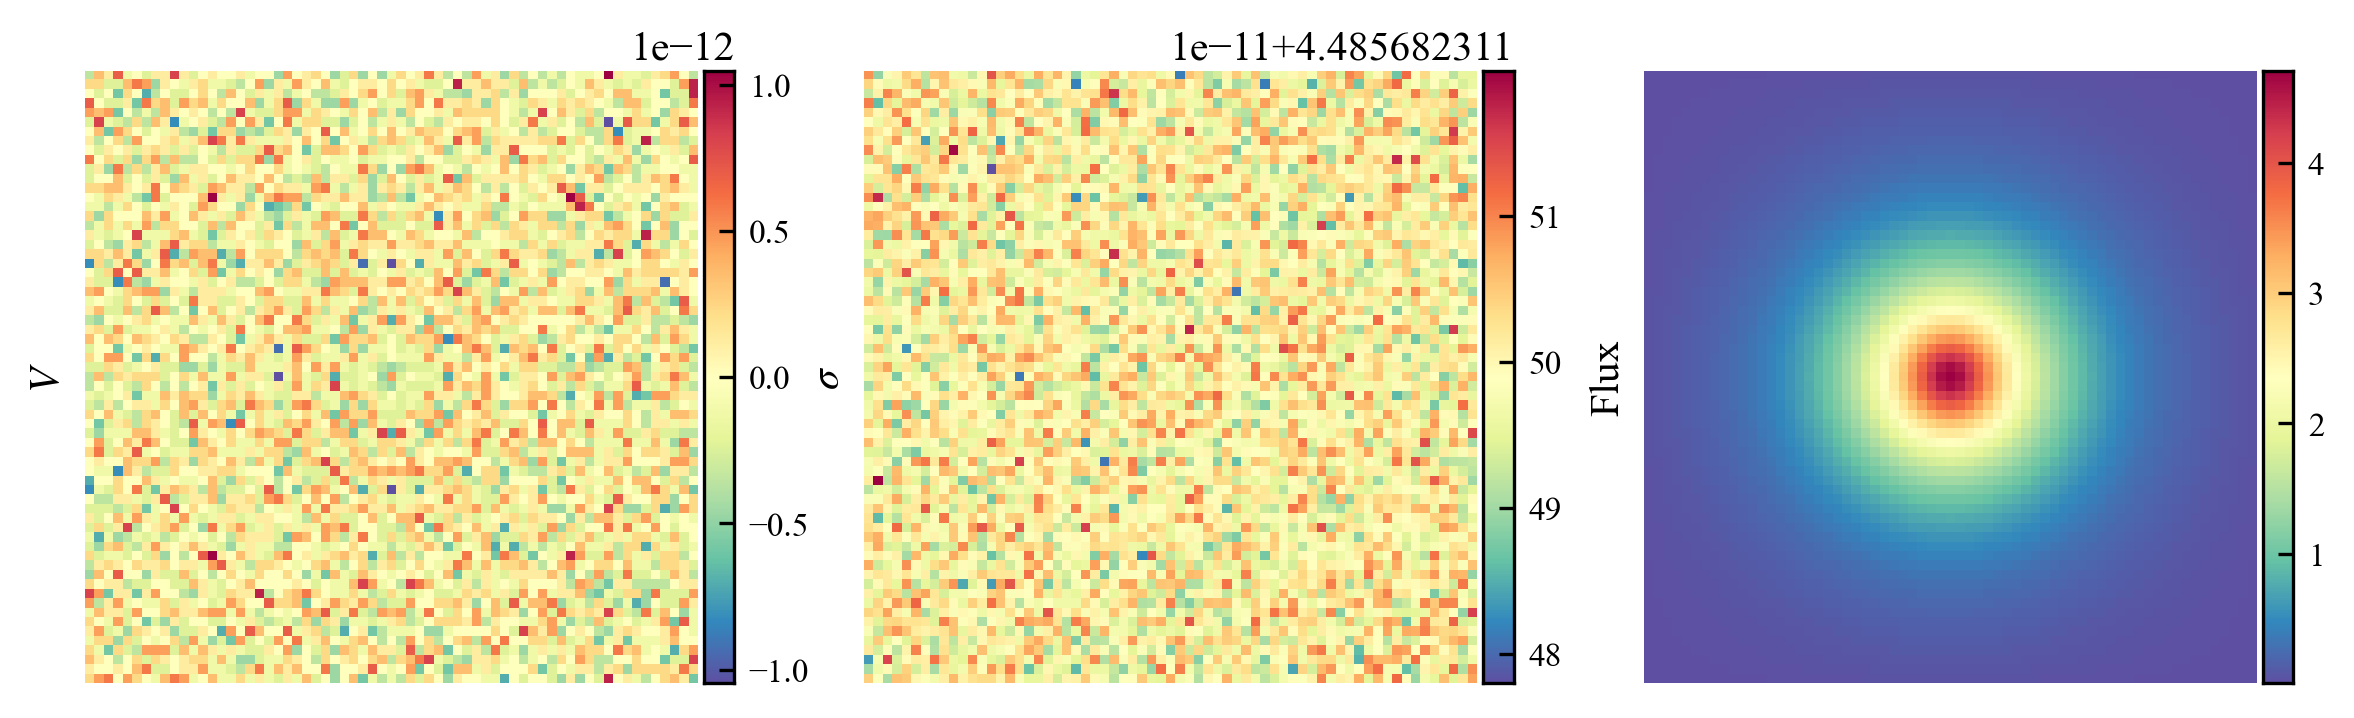

In [21]:
plotting.plot_model_2D(galFO, inst_corr=True, fitflux=True)

---------

--------

### Hack 2: BH with LSersic=1, truncated

In [22]:
reload(models)
reload(galaxy)

<module 'dysmalpy.galaxy' from '/Users/sedona/software_public/dysmalpy/dysmalpy/galaxy.py'>

In [23]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [24]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [25]:
BH = models.BlackHole(BH_mass=9.,name='BH')
TSersic = models.LightTruncateSersic(r_eff=5., n =1., L_tot=1., 
                                     r_inner=5., r_outer=10., name='TSersic')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [26]:
sigmaz = 1.   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [27]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [28]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [29]:
mod_setFO.add_component(BH)
mod_setFO.add_component(TSersic, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [30]:
mod_setEO.add_component(BH)
mod_setEO.add_component(TSersic, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [31]:
beamsize = 0.2*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

# beam = None
# lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

In [32]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [33]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

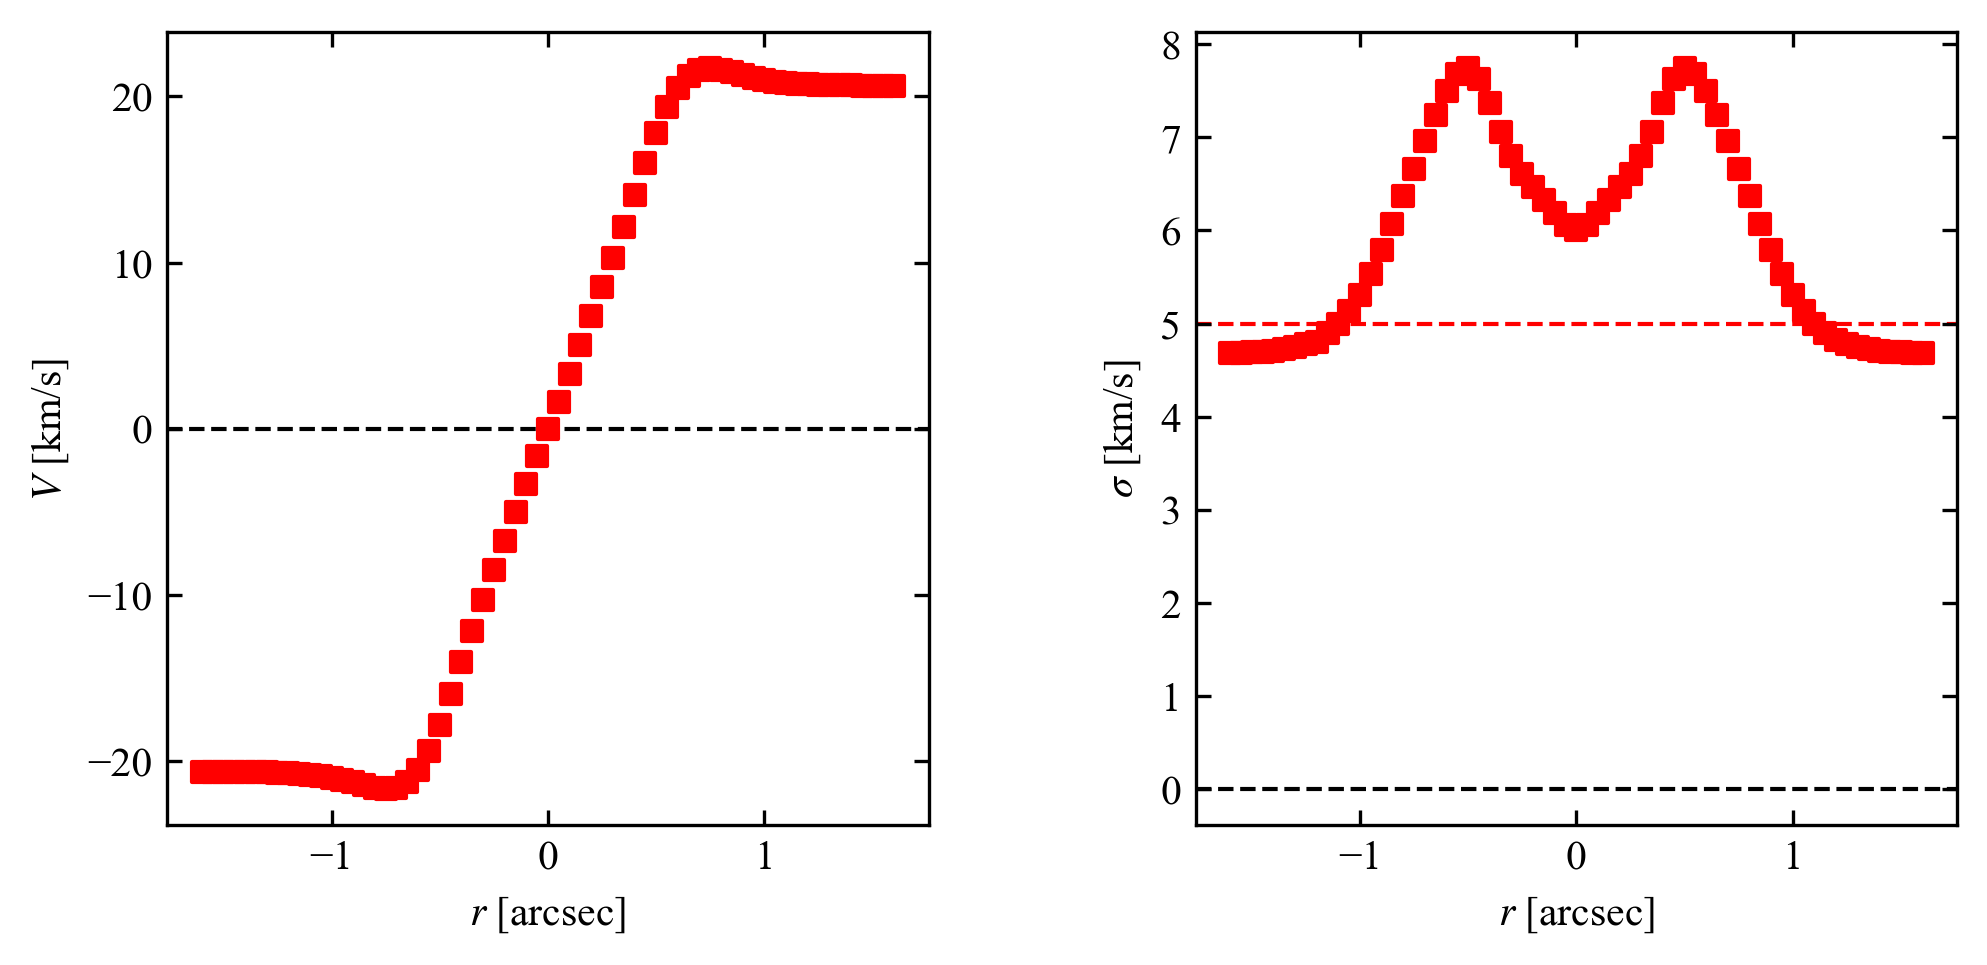

In [34]:
plotting.plot_model_1D(galEO, inst_corr=True, best_dispersion=sigma0)

### 2D model

In [35]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

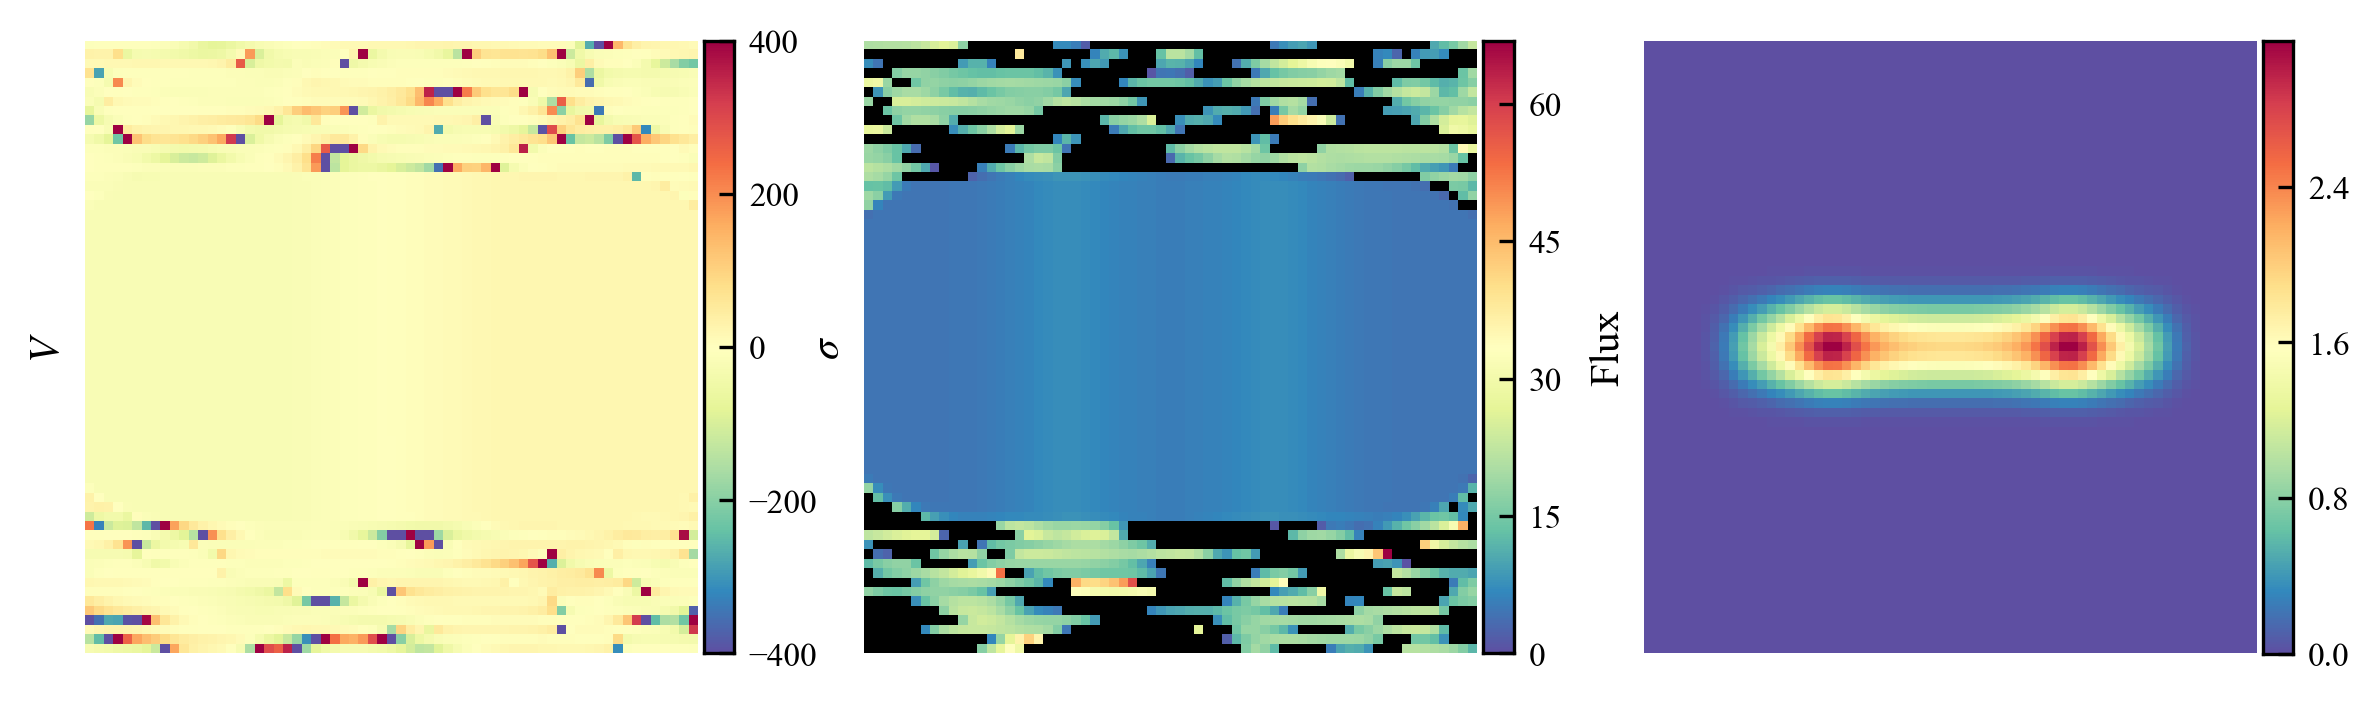

In [36]:
plotting.plot_model_2D(galEO, inst_corr=True, fitflux=True)

### 2D model

In [37]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

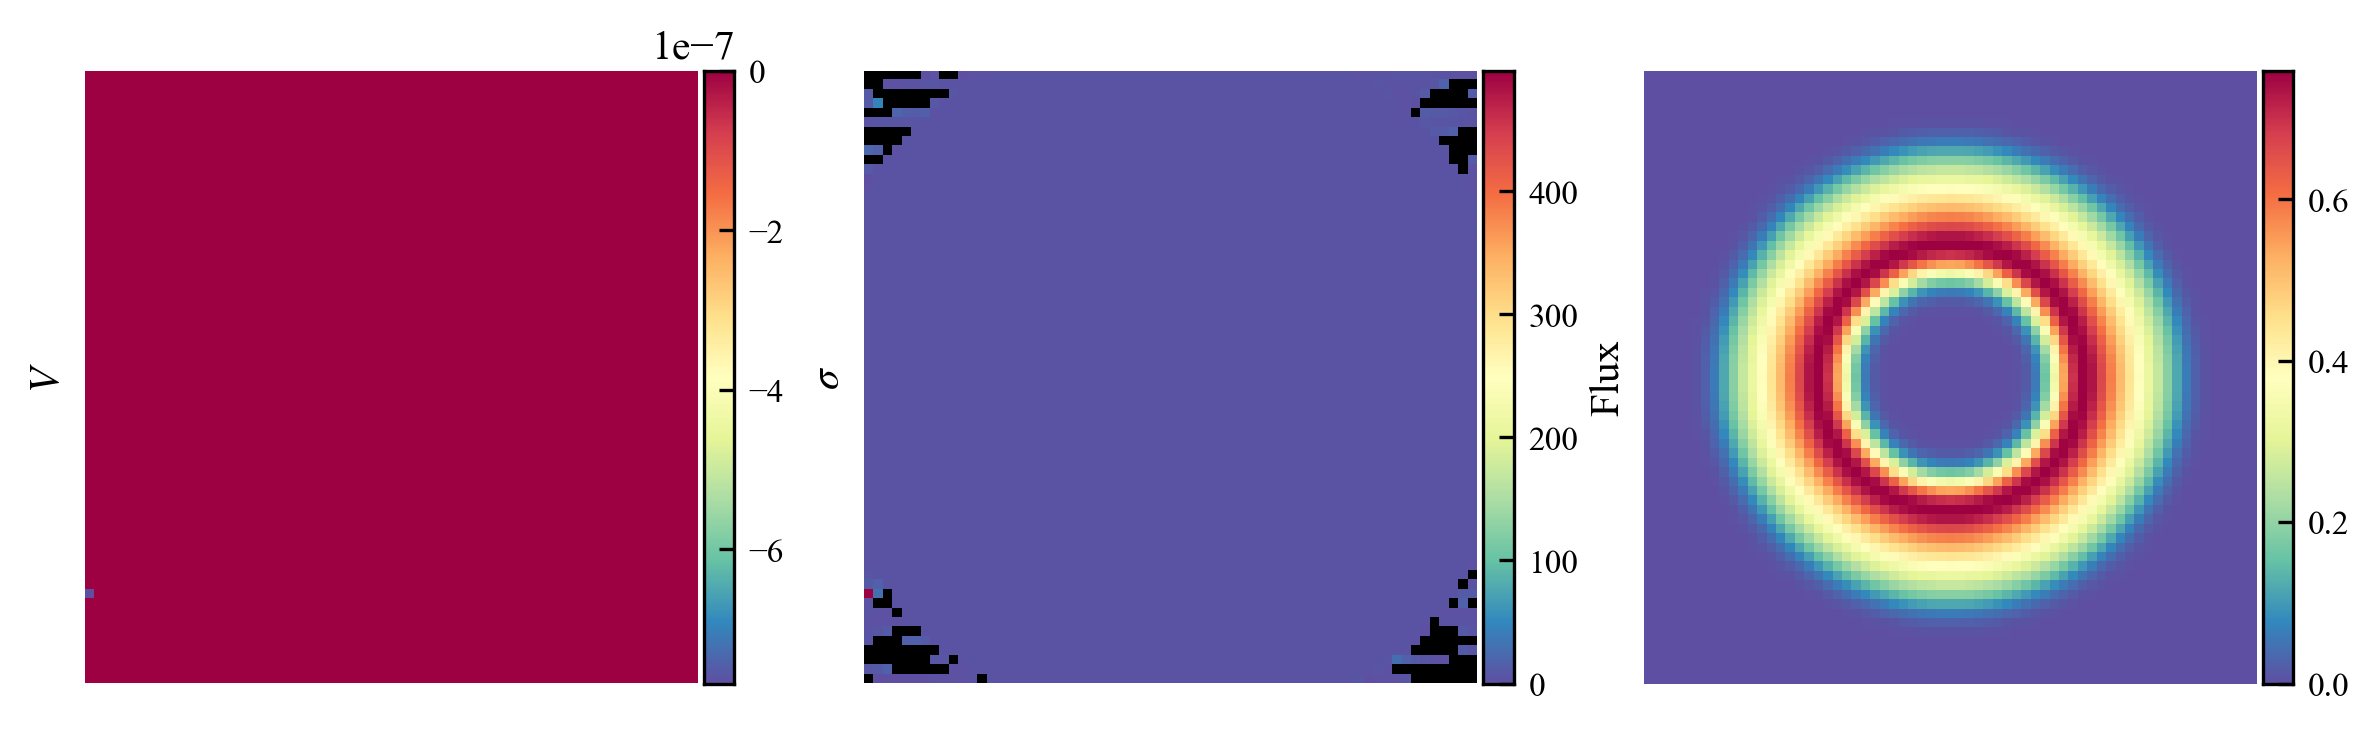

In [38]:
plotting.plot_model_2D(galFO, inst_corr=True, fitflux=True)

---------

--------

### Hack 3: BH with GaussianRing

In [39]:
reload(models)

<module 'dysmalpy.models' from '/Users/sedona/software_public/dysmalpy/dysmalpy/models.py'>

In [40]:
galEO = galaxy.Galaxy(z=2., name='galaxy')
mod_setEO = models.ModelSet()
inst = instrument.Instrument()

In [41]:
galFO = galaxy.Galaxy(z=2., name='galaxy')
mod_setFO = models.ModelSet()
inst = instrument.Instrument()

In [42]:
BH = models.BlackHole(BH_mass=9.,name='BH')
GR = models.LightGaussianRing(r_peak=5., sigma_r =1., L_tot=1., name='GaussianRing')

sigma0 = 5. #10. #10. #0.1
disp_prof = models.DispersionConst(sigma0=sigma0, name='dispprof')

In [43]:
sigmaz = 1.  # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tied_functions.tie_sigz_reff

In [44]:
inc = 90. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomEO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [45]:
inc = 0. #45.     # degrees
pa = 90. #0.    # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geomFO = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

In [46]:
mod_setFO.add_component(BH)
mod_setFO.add_component(GR, light=True)
mod_setFO.add_component(disp_prof)
mod_setFO.add_component(zheight_prof)
mod_setFO.add_component(geomFO)
mod_setFO.kinematic_options.adiabatic_contract = False
mod_setFO.kinematic_options.pressure_support = False

galFO.model = mod_setFO

In [47]:
mod_setEO.add_component(BH)
mod_setEO.add_component(GR, light=True)
mod_setEO.add_component(disp_prof)
mod_setEO.add_component(zheight_prof)
mod_setEO.add_component(geomEO)
mod_setEO.kinematic_options.adiabatic_contract = False
mod_setEO.kinematic_options.pressure_support = False

galEO.model = mod_setEO

In [48]:
beamsize = 0.2*u.arcsec #0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

# beam = None
# lsf = None

inst.pixscale = 0.05*u.arcsec #0.125*u.arcsec           # arcsec/pixel
inst.fov = [65,65] #[33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels


inst.beam = beam
inst.lsf = lsf
# # Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

In [49]:
galFO.instrument = inst
galEO.instrument = inst

### 1D model

In [50]:
aper_arr = np.linspace(-(inst.fov[0]-1)/2., (inst.fov[0]-1)/2., 
                           num=inst.fov[0])*inst.pixscale.value
galEO.create_model_data(oversample=3, ndim_final=1, from_data=False, 
                            slit_width = beamsize.value, slit_pa=pa, 
                            aper_centers=aper_arr, 
                     profile1d_type='circ_ap_cube')

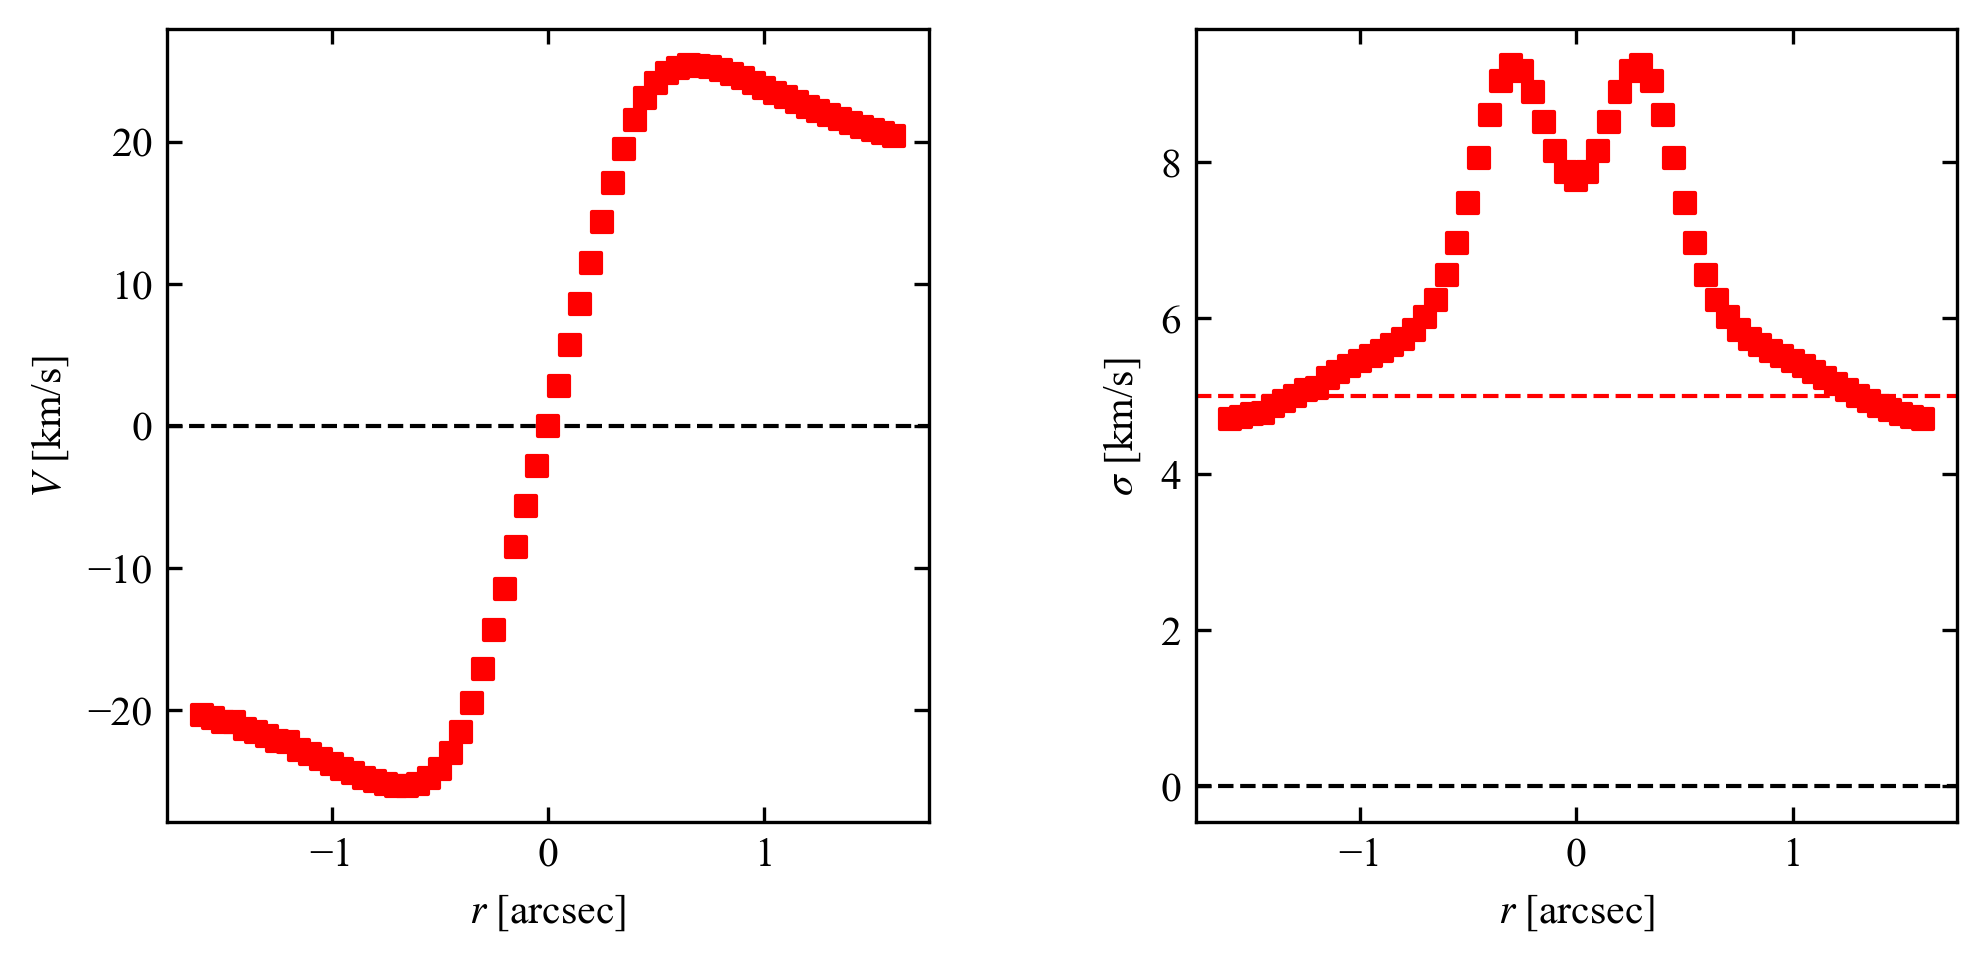

In [51]:
plotting.plot_model_1D(galEO, inst_corr=True, best_dispersion=sigma0)

### 2D model

In [52]:
galEO.create_model_data(oversample=3, ndim_final=2, from_data=False)

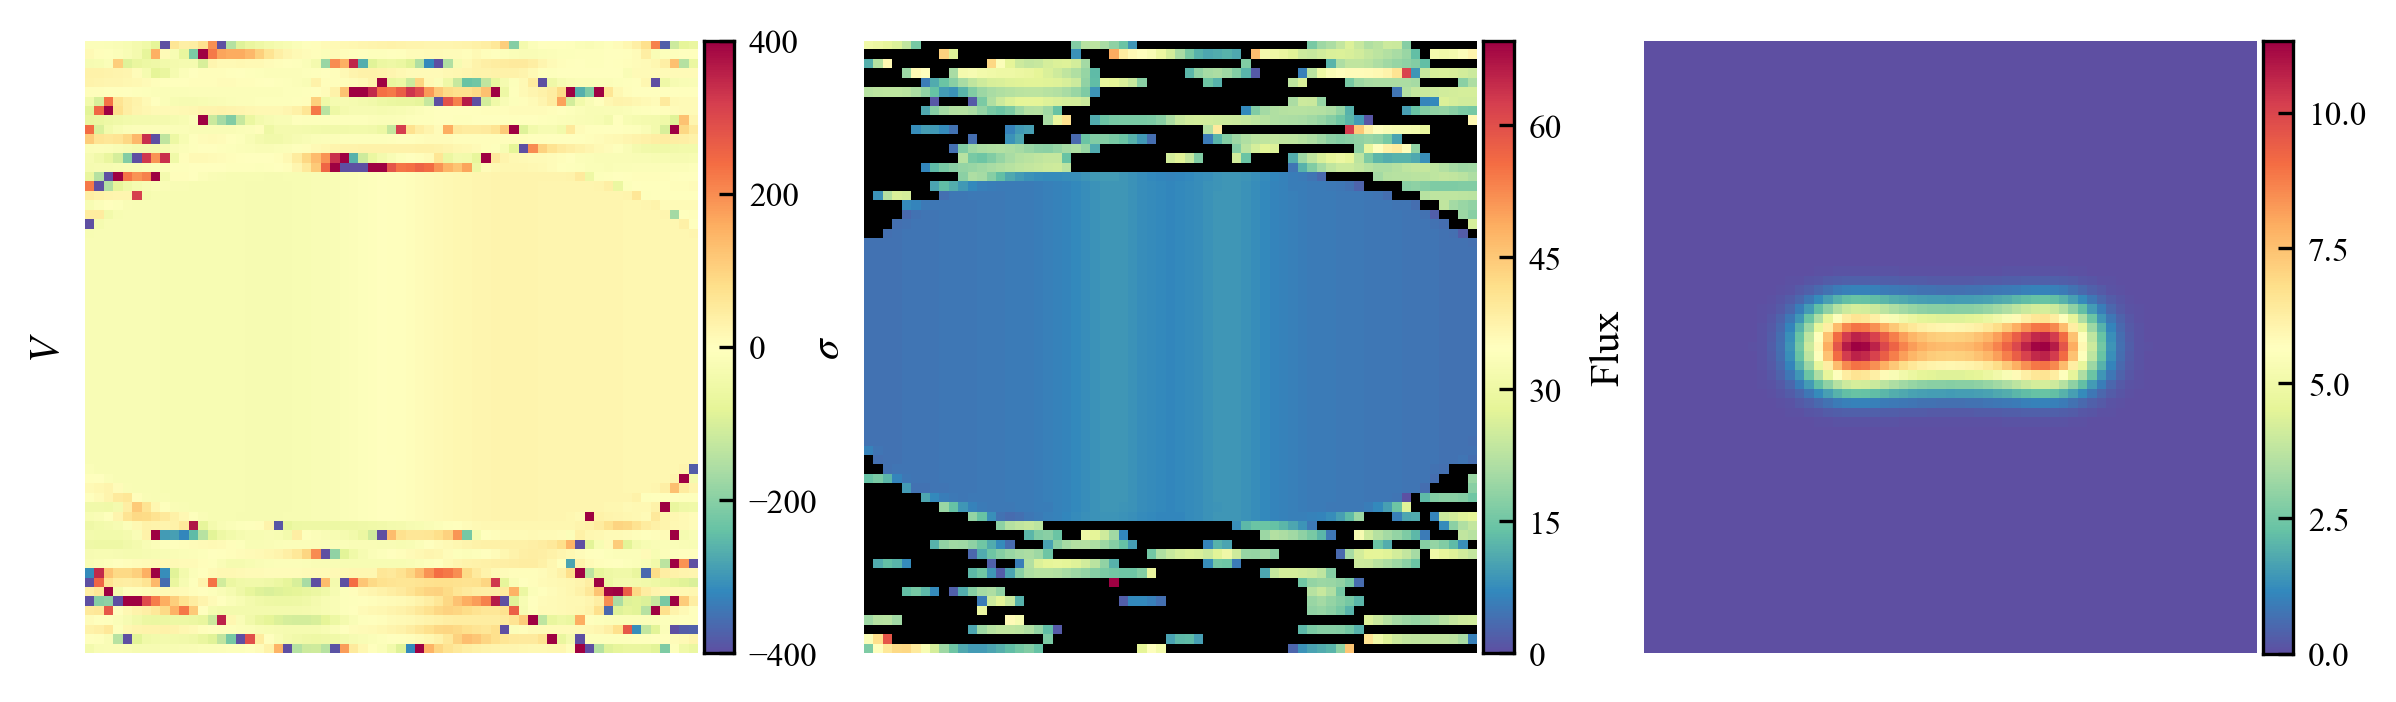

In [53]:
plotting.plot_model_2D(galEO, inst_corr=True, fitflux=True)

### 2D model

In [54]:
galFO.create_model_data(oversample=3, ndim_final=2, from_data=False)

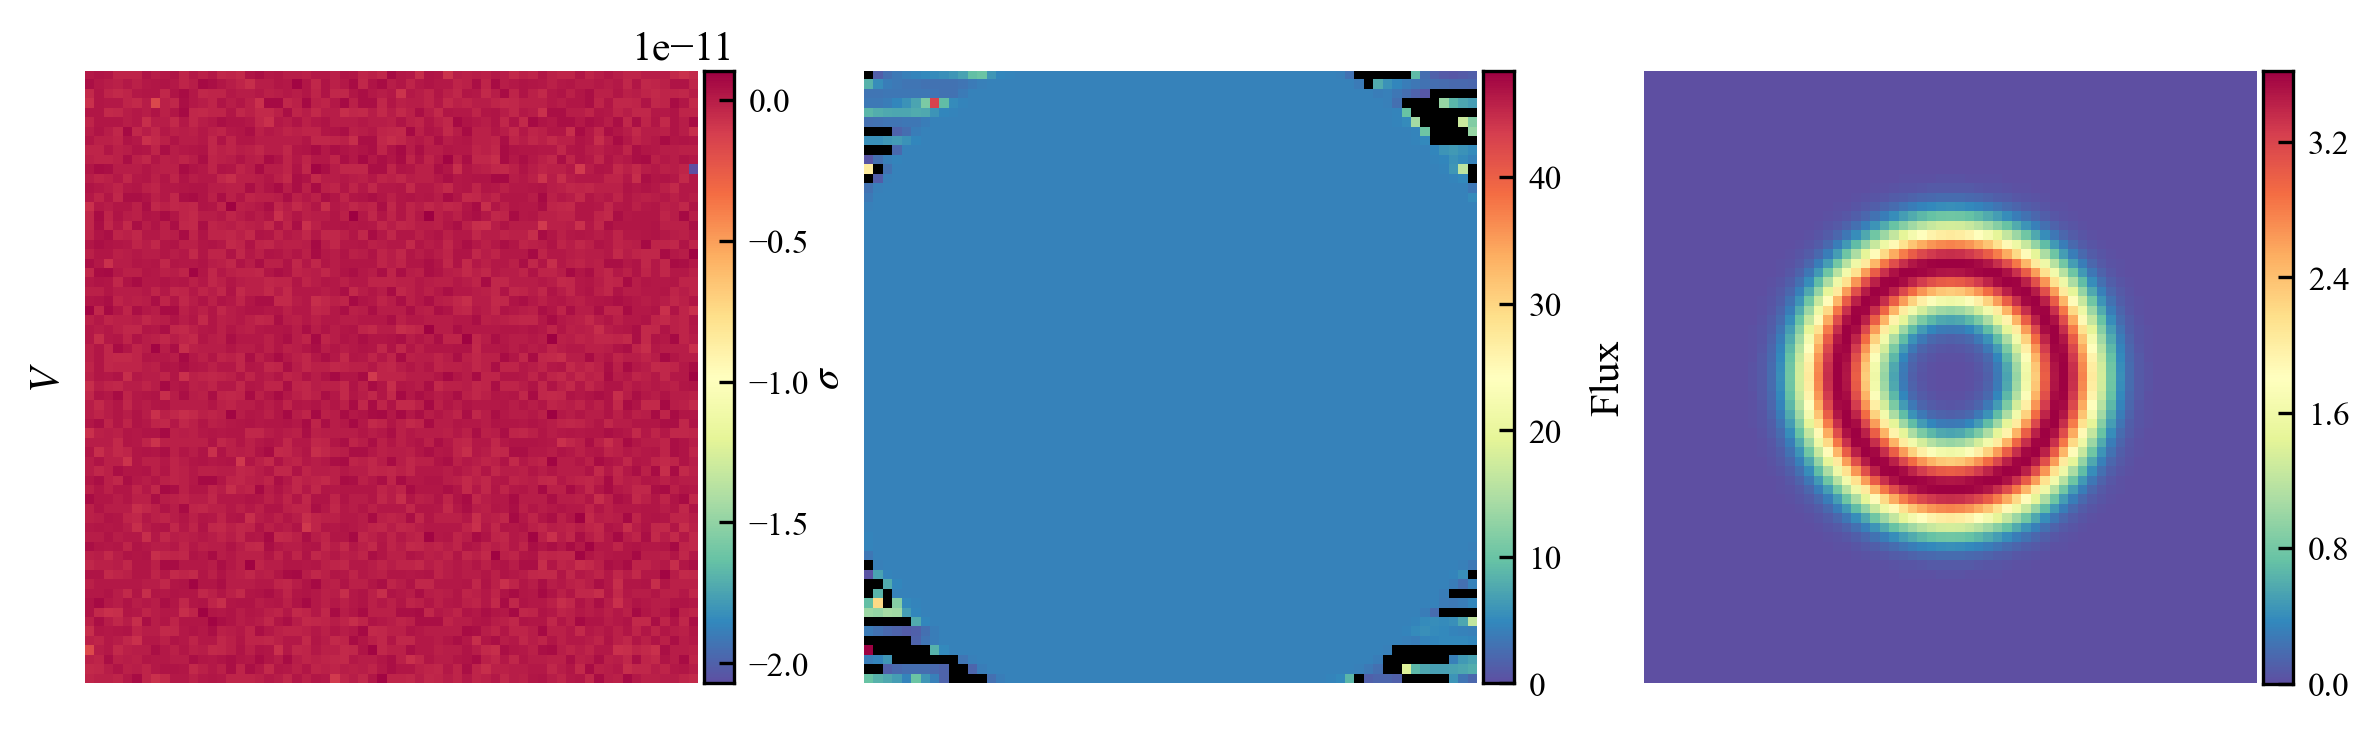

In [55]:
plotting.plot_model_2D(galFO, inst_corr=True, fitflux=True)

In [56]:
light_components_list_orig = []

---------

In [57]:
len(light_components_list_orig)

0

--------